In [19]:
!pip install torch torchvision torchaudio 

In [20]:
!pip install pyspark matplotlib numpy pandas 

#conda install -c conda-forge openjdk=17 -y also included
#setx JAVA_HOME "%CONDA_PREFIX%"

In [65]:
!pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ----------------------- ---------------- 5.2/8.9 MB 31.9 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 24.1 MB/s eta 0:00:00
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- -

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("Fraud_Detection").getOrCreate()
print("Spark version:", spark.version)

Spark version: 4.0.0


In [22]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

schema = StructType([
    StructField("step", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("amount", DoubleType(), True),
    StructField("nameOrig", StringType(), True),
    StructField("oldbalanceOrg", DoubleType(), True),
    StructField("newbalanceOrig", DoubleType(), True),
    StructField("nameDest", StringType(), True),
    StructField("oldbalanceDest", DoubleType(), True),
    StructField("newbalanceDest", DoubleType(), True),
    StructField("isFraud", IntegerType(), True),
    StructField("isFlaggedFraud", IntegerType(), True)
])

df = spark.read.csv("Fraud.csv", header=True, schema=schema).cache()

print(f"Dataset loaded: {df.count():,} rows x {len(df.columns)} columns")
df.printSchema()


Dataset loaded: 6,362,620 rows x 11 columns
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [ ]:
total_rows = df.count()

fraud_dist = (
    df.groupBy("IsFraud")
      .agg(count("*").alias("Transactions"))
      .withColumn("Percentage", round((col("Transactions") / total_rows) * 100, 4))
      .orderBy("IsFraud")
)
fraud_dist.show()

type_fraud = (
    df.groupBy("Type")
      .agg(
          count("*").alias("Total_Transactions"),
          sum("IsFraud").alias("Fraud_Transactions")
      )
      .withColumn("Fraud_Rate", round((col("Fraud_Transactions") / col("Total_Transactions")) * 100, 4))
      .orderBy(col("Fraud_Rate").desc())
)
type_fraud.show()


+-------+------------+----------+
|IsFraud|Transactions|Percentage|
+-------+------------+----------+
|      0|     6354407|   99.8709|
|      1|        8213|    0.1291|
+-------+------------+----------+

+--------+------------------+------------------+----------+
|    Type|Total_Transactions|Fraud_Transactions|Fraud_Rate|
+--------+------------------+------------------+----------+
|TRANSFER|            532909|              4097|    0.7688|
|CASH_OUT|           2237500|              4116|     0.184|
| CASH_IN|           1399284|                 0|       0.0|
| PAYMENT|           2151495|                 0|       0.0|
|   DEBIT|             41432|                 0|       0.0|
+--------+------------------+------------------+----------+



In [ ]:
print("Missing Values:")
missing = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])
missing.show(truncate=False)

#Zero balances (potential issues)
print("\nZero Balance Counts:")
zero_balances = df.select(
    sum((col("oldbalanceOrg") == 0).cast("int")).alias("oldbalanceOrg"),
    sum((col("newbalanceOrig") == 0).cast("int")).alias("newbalanceOrig"),
    sum((col("oldbalanceDest") == 0).cast("int")).alias("oldbalanceDest"),
    sum((col("newbalanceDest") == 0).cast("int")).alias("newbalanceDest")
)
zero_balances.show(truncate=False)

Data Quality Analysis:
Missing Values:
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|0   |0   |0     |0       |0            |0             |0       |0             |0             |0      |0             |
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+


Zero Balance Counts:
+-------------+--------------+--------------+--------------+
|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|
+-------------+--------------+--------------+--------------+
|2102449      |3609566       |2704388       |2439433       |
+-------------+--------------+--------------+--------------+



**Formula = percent = (col("zero_newbalanceOrig") / col("total_txn")) * 100
We use the values found in the below code to calculate how much percentage each column contributes towards fraud.
98% times the zero old balance ends with 0 incase of fraud transaction.**


In [ ]:

df.groupBy("isFraud").agg(
    sum((col("oldbalanceOrg") == 0).cast("int")).alias("zero_oldbalanceOrg"),
    sum((col("newbalanceOrig") == 0).cast("int")).alias("zero_newbalanceOrig"),
    sum((col("oldbalanceDest") == 0).cast("int")).alias("zero_oldbalanceDest"),
    sum((col("newbalanceDest") == 0).cast("int")).alias("zero_newbalanceDest"),
    count("*").alias("total_txn")
).show()


+-------+------------------+-------------------+-------------------+-------------------+---------+
|isFraud|zero_oldbalanceOrg|zero_newbalanceOrig|zero_oldbalanceDest|zero_newbalanceDest|total_txn|
+-------+------------------+-------------------+-------------------+-------------------+---------+
|      1|                41|               8053|               5351|               4091|     8213|
|      0|           2102408|            3601513|            2699037|            2435342|  6354407|
+-------+------------------+-------------------+-------------------+-------------------+---------+



In [ ]:

df.groupBy("isFraud").agg(
    sum((col("oldbalanceOrg") == 0).cast("int")).alias("zero_oldbalanceOrg"),
    sum((col("newbalanceOrig") == 0).cast("int")).alias("zero_newbalanceOrig"),
    sum((col("oldbalanceDest") == 0).cast("int")).alias("zero_oldbalanceDest"),
    sum((col("newbalanceDest") == 0).cast("int")).alias("zero_newbalanceDest"),
    count("*").alias("total_txn")
).show()


+-------+------------------+-------------------+-------------------+-------------------+---------+
|isFraud|zero_oldbalanceOrg|zero_newbalanceOrig|zero_oldbalanceDest|zero_newbalanceDest|total_txn|
+-------+------------------+-------------------+-------------------+-------------------+---------+
|      1|                41|               8053|               5351|               4091|     8213|
|      0|           2102408|            3601513|            2699037|            2435342|  6354407|
+-------+------------------+-------------------+-------------------+-------------------+---------+



In [30]:
new_df = df.withColumn(
    "balance_change_orig", col("newbalanceOrig") - col("oldbalanceOrg") #Measures how much the origin account balance changed after the transaction.Change =-transaction inorder for it to be real.
).withColumn(
    "balance_change_dest", col("newbalanceDest") - col("oldbalanceDest") #Measures how much the destination account balance changed after the transaction.Change =+transaction inorder for it to be real.
).withColumn(
    "is_merchant", col("nameDest").startswith("M").cast("int") #Creates a binary feature for merchant.
).withColumn(
    "hour_of_day", col("step") % 24 #Convert to 24hr format
).withColumn(
    "is_round_amount", (col("amount") % 100000 == 0).cast("int") #Flags round amount transactions(Normal transactions are more normal)
).withColumn(
    "balance_error_orig", 
    abs(col("balance_change_orig") + col("amount")).cast("int") #balance_change_orig + amount = 0 for real.
)

In [39]:
new_df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+-------------------+-----------+-----------+---------------+------------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|balance_change_orig|balance_change_dest|is_merchant|hour_of_day|is_round_amount|balance_error_orig|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-------------------+-------------------+-----------+-----------+---------------+------------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0| -9839.640000000014|                0.0|          1|          1|              0|                 0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|   

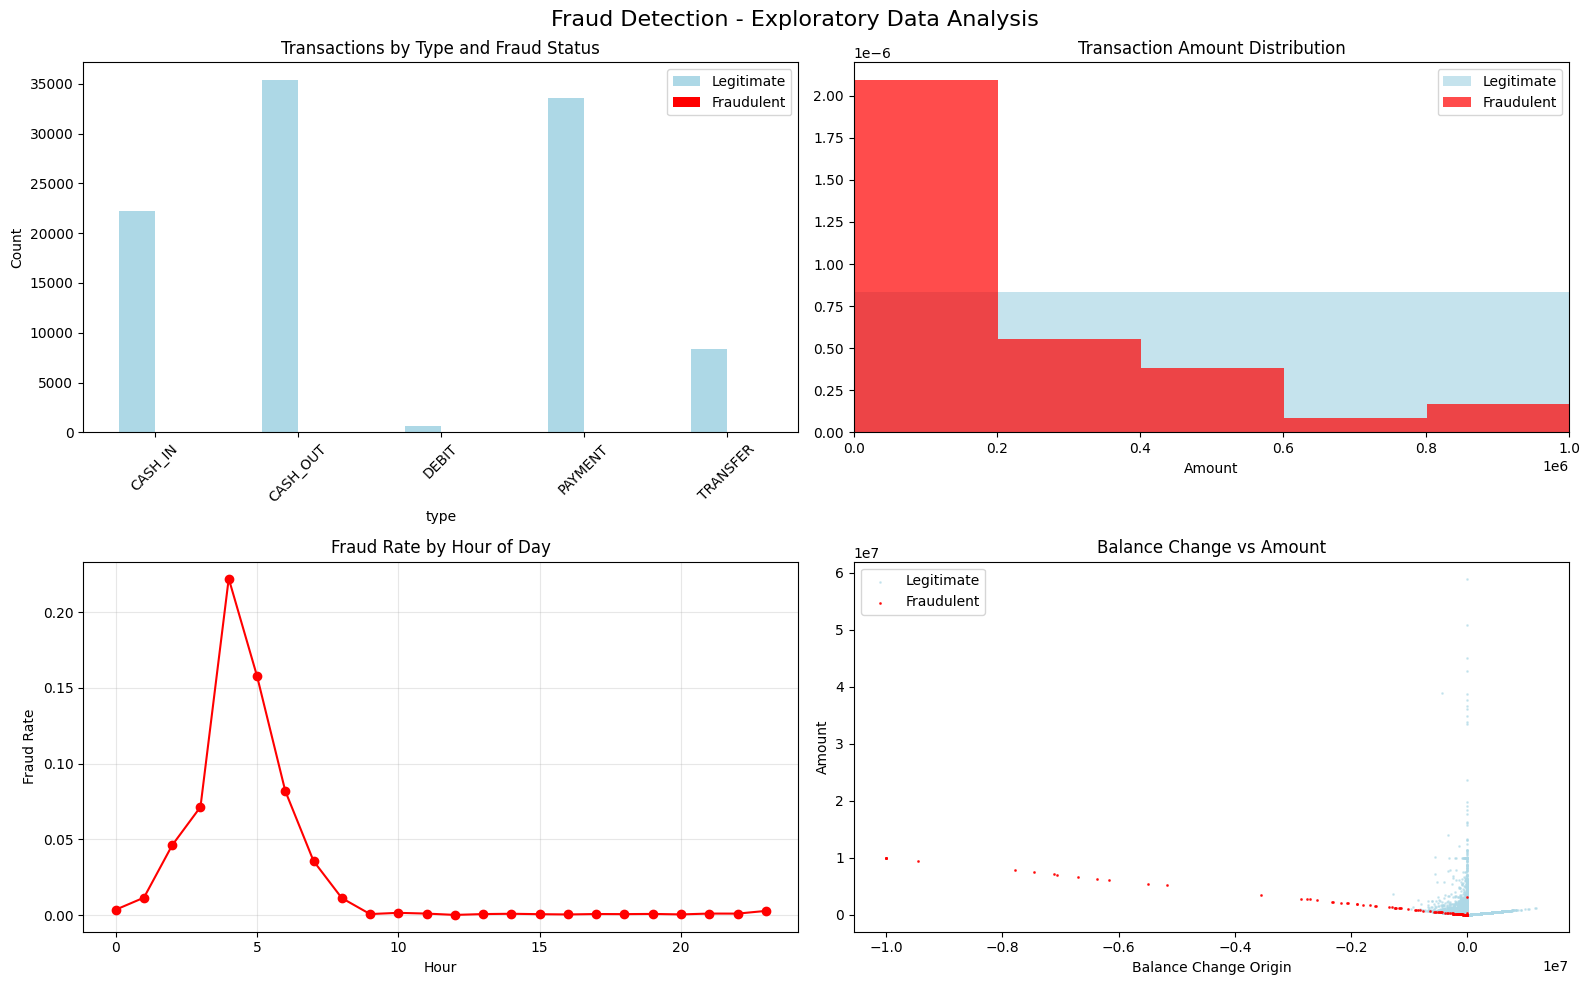

In [ ]:
import builtins
import matplotlib.pyplot as plt

def create_eda_plots(df_spark):
    # Converting samples to pandas for plotting
    row_count = df_spark.count()
    sample_size = builtins.min(100000, row_count)
    df_sample = df_spark.sample(
        fraction=sample_size / row_count, seed=42
    ).toPandas()
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1.Fraud by transaction type
    fraud_by_type = df_sample.groupby(['type', 'isFraud']).size().unstack(fill_value=0)
    fraud_by_type.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'red'])
    axes[0,0].set_title('Transactions by Type and Fraud Status')
    axes[0,0].set_ylabel('Count')
    axes[0,0].legend(['Legitimate', 'Fraudulent'])
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2.Transaction amount distribution
    legit = df_sample[df_sample['isFraud']==0]['amount']
    fraud = df_sample[df_sample['isFraud']==1]['amount']
    axes[0,1].hist(legit, bins=50, alpha=0.7, label='Legitimate', color='lightblue', density=True)
    axes[0,1].hist(fraud, bins=50, alpha=0.7, label='Fraudulent', color='red', density=True)
    axes[0,1].set_title('Transaction Amount Distribution')
    axes[0,1].set_xlabel('Amount')
    axes[0,1].set_xlim(0, 1000000)
    axes[0,1].legend()
    
    # 3.Fraud by hour
    hourly = df_sample.groupby('hour_of_day')['isFraud'].agg(['count', 'sum'])
    hourly['fraud_rate'] = hourly['sum'] / hourly['count']
    axes[1,0].plot(hourly.index, hourly['fraud_rate'], 'ro-')
    axes[1,0].set_title('Fraud Rate by Hour of Day')
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('Fraud Rate')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4.Balance change vs amount
    axes[1,1].scatter(df_sample[df_sample['isFraud']==0]['balance_change_orig'], 
                     df_sample[df_sample['isFraud']==0]['amount'], 
                     alpha=0.5, s=1, color='lightblue', label='Legitimate')
    axes[1,1].scatter(df_sample[df_sample['isFraud']==1]['balance_change_orig'], 
                     df_sample[df_sample['isFraud']==1]['amount'], 
                     alpha=0.8, s=1, color='red', label='Fraudulent')
    axes[1,1].set_title('Balance Change vs Amount')
    axes[1,1].set_xlabel('Balance Change Origin')
    axes[1,1].set_ylabel('Amount')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

create_eda_plots(new_df)


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import torch 
from torch.utils.data import TensorDataset, DataLoader

print("Preprocessing data in PySpark for PyTorch...")

#Features
feature_cols = [
    "step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", 
    "newbalanceDest", "balance_change_orig", "balance_change_dest",
    "is_merchant", "hour_of_day", "is_round_amount", "balance_error_orig"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")

scaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True, withMean=True)

pipeline = Pipeline(stages=[assembler, scaler])
pipeline_model = pipeline.fit(new_df)
df_processed = pipeline_model.transform(new_df).select("features", "isFraud")

train_df, test_df = df_processed.randomSplit([0.8, 0.2], seed=42)

def spark_to_tensors(df, print_every=1000000):
    features, labels = [], []
    for i, row in enumerate(df.toLocalIterator(), 1):   # streams rows
        features.append(row["features"].toArray())
        labels.append(int(row["isFraud"]))
        if i % print_every == 0:
            print(f"Processed {i} rows...")
    
    print(f"Finished processing {i} rows.")
    X_tensor = torch.tensor(features, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

X_train, y_train = spark_to_tensors(train_df)
X_test,  y_test  = spark_to_tensors(test_df)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=1024, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Preprocessing data in PySpark for PyTorch...
Processed 1000000 rows...
Processed 2000000 rows...
Processed 3000000 rows...
Processed 4000000 rows...
Processed 5000000 rows...
Finished processing 5090065 rows.
Processed 1000000 rows...
Finished processing 1272555 rows.
✅ Data ready for PyTorch!
Train batches: 4971, Test batches: 1243


**Every Neuron here are our hyper parameter. We have to modify this according to how our model behaves.
Dropout layers are used to makesure that our model doesnt overfit to the training data.**

In [ ]:
import torch.nn as nn
import torch.optim as optim

class FraudNet(nn.Module):
    def __init__(self, input_size):
        super(FraudNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),   
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


In [82]:
model = FraudNet(12)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

n_epochs = 2
train_losses, test_losses = [], []
train_prec, train_rec, train_f1, train_auc = [], [], [], []
test_prec, test_rec, test_f1, test_auc = [], [], [], []

for epoch in range(n_epochs):
    # ----- Training -----
    model.train()
    total_loss, all_preds, all_labels = 0, [], []
    
    for i, (X_batch, y_batch) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = loss_fn(preds, y_batch.float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y_batch)
        all_preds.append(preds.detach())
        all_labels.append(y_batch)
        
        # Print every 1000 batches
        if i % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {i}/{len(train_loader)} - Train Loss: {loss.item():.4f}")
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    predicted_labels = (all_preds >= 0.2).long()
    
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_prec.append(precision_score(all_labels, predicted_labels))
    train_rec.append(recall_score(all_labels, predicted_labels))
    train_f1.append(f1_score(all_labels, predicted_labels))
    train_auc.append(roc_auc_score(all_labels, all_preds))
    
    # ----- Testing -----
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader, 1):
            preds = model(X_batch).squeeze()
            loss = loss_fn(preds, y_batch.float())
            total_loss += loss.item() * len(y_batch)
            all_preds.append(preds)
            all_labels.append(y_batch)
            
            # Print every 1000 batches
            if i % 1000 == 0:
                print(f"Epoch {epoch+1}, Test Batch {i}/{len(test_loader)} - Test Loss: {loss.item():.4f}")
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    predicted_labels = (all_preds >= 0.1).long()
    
    test_loss = total_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_prec.append(precision_score(all_labels, predicted_labels))
    test_rec.append(recall_score(all_labels, predicted_labels))
    test_f1.append(f1_score(all_labels, predicted_labels))
    test_auc.append(roc_auc_score(all_labels, all_preds))
    
    # ----- Summary -----
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Prec: {train_prec[-1]:.4f}, Rec: {train_rec[-1]:.4f}, F1: {train_f1[-1]:.4f}, AUC: {train_auc[-1]:.4f}")
    print(f"Test  Loss: {test_loss:.4f}, Prec: {test_prec[-1]:.4f}, Rec: {test_rec[-1]:.4f}, F1: {test_f1[-1]:.4f}, AUC: {test_auc[-1]:.4f}")


Epoch 1, Batch 1000/4971 - Train Loss: 0.0001
Epoch 1, Batch 2000/4971 - Train Loss: 0.0071
Epoch 1, Batch 3000/4971 - Train Loss: 0.0004
Epoch 1, Batch 4000/4971 - Train Loss: 0.0004
Epoch 1, Test Batch 1000/1243 - Test Loss: 0.0001

Epoch 1/2
Train Loss: 0.0023, Prec: 0.7959, Rec: 0.7872, F1: 0.7915, AUC: 0.9940
Test  Loss: 0.0020, Prec: 0.6673, Rec: 0.8768, F1: 0.7578, AUC: 0.9938
Epoch 2, Batch 1000/4971 - Train Loss: 0.0002
Epoch 2, Batch 2000/4971 - Train Loss: 0.0001
Epoch 2, Batch 3000/4971 - Train Loss: 0.0004
Epoch 2, Batch 4000/4971 - Train Loss: 0.0003
Epoch 2, Test Batch 1000/1243 - Test Loss: 0.0000

Epoch 2/2
Train Loss: 0.0023, Prec: 0.7919, Rec: 0.7893, F1: 0.7906, AUC: 0.9938
Test  Loss: 0.0021, Prec: 0.7201, Rec: 0.8553, F1: 0.7819, AUC: 0.9940


In [96]:
model_path = "fraud_detection_model.pth"

torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at fraud_detection_model.pth


# Fraud Detection Analysis

## 1. Data Cleaning (Missing Values, Outliers, and Multi-Collinearity)

**Ans.**  
- Missing values can cause improper training to our model. In this dataset, there weren't any missing values but there were zero values which were used to find similarities between fraud and real transactions.  
- Outliers can either be removed if in lower number or handled by capping at the 99th percentile or using log transformations to reduce their impact. IQR is used to find outliers.  
- Multi-collinearity means certain features are linearly dependent. You can remove these columns because one column can mathematically produce the other column.

---

## 2. Describe Your Fraud Detection Model

**Ans.**  
- The model uses **Neural Networks** to detect whether a transaction is fraud or not.  
- Initial lines of code perform **EDA** to understand the data.  
- **PySpark** is used for handling large data, while **PyTorch** is used for model training.  
- **Recall score is prioritized** because false positives are bearable in this use case.  
- Recall and precision are inversely related.

---

## 3. Variable Selection

**Ans.**  
- ID columns were dropped and the remaining columns were used.  
- Additional engineered features were created to provide more insight into the data.

---

## 4. Model Performance

**Ans.**  

**Train:**  
- Loss: 0.0023  
- Precision: 0.7919  
- Recall: 0.7893  
- F1: 0.7906  
- AUC: 0.9938  

**Test:**  
- Loss: 0.0021  
- Precision: 0.7201  
- Recall: 0.8553  
- F1: 0.7819  
- AUC: 0.9940  

**Metrics Explained:**  
- **Precision:** 72.01% of predicted frauds were actually fraudulent.  
- **Recall:** 85.53% of all actual fraudulent transactions were correctly identified.  
- **F1:** Harmonic mean of precision and recall.  
- **AUC:** Model effectively separates frauds from non-frauds.

---

## 5. Key Factors Predicting Fraudulent Customers

**Ans.**  
- Most fraud transactions happen at particular times.  
- Transaction amount and balance changes – large or unusual transfers, or sudden changes in account balances, are strong indicators of fraud.  
- Transactions where `zero_old_acc` ends up with 0 often indicate fraudulent behavior.

---

## 6. Do These Factors Make Sense?

**Ans.**  
- Yes, they align with typical patterns of fraudulent behavior:  
  - **Time of Transaction:** Fraudsters often target hours with lower monitoring.  
  - **Transaction Amount & Balance Changes:** Sudden large transfers or unexpected balance changes are red flags.  
  - **Zero_old_acc ending up 0:** May indicate synthetic or test accounts used for fraud.

---

## 7. Prevention Measures During Infrastructure Updates

**Ans.**  
- Encrypt sensitive user data and ensure no coding loopholes.  
- Hire bug finders or white-hat hackers to identify vulnerabilities.  
- Enforce strong authentication systems.  
- Monitor and store audit logs regularly.

---

## 8. How to Determine If These Actions Work

**Ans.**  
- Periodically run internal audits and hire external white-hat hackers for penetration testing.  
- Track metrics like unauthorized access attempts, successful breaches, and suspicious activity alerts.  
- Collect and analyze user reports on suspicious activity.  
- Regularly review encryption protocols and authentication systems.
